In [76]:
!pip install transformers

In [77]:
# импорт необходимых библиотек

import pandas as pd # табличное представление и чтение|запись csv
import numpy as np # векторы, матрицы
import random # случайный генератор
import time # измерение времени
import matplotlib.pyplot as plt # график, визуализация
import seaborn as sns
from nltk.stem import WordNetLemmatizer
# предобработка текста
import nltk
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # токенизация по словам

from sklearn.model_selection import train_test_split # разделение на тестовую и тренировочную выборки
import re # удаление знаков препинания через регулярное выражение

# нейронные слои
import torch
import torch.nn as nn # настройка нейросети (класс родитель)
import torch.optim as optim # оптимизация
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler # объекты настройки
import torch.nn.functional as F # функция softmax

# трансформеры, предобученные
from transformers import BertModel # класс модели BERT
from transformers import AdamW, get_linear_schedule_with_warmup # оптимизатор и загрузчик
from transformers import BertTokenizer, BertForSequenceClassification # Токенизатор, классификатор

from sklearn.metrics import accuracy_score, roc_curve, auc # метрики классификации

In [78]:
df = pd.read_csv("/content/sample_data/news.csv")
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [79]:
df.info() #информация о сете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


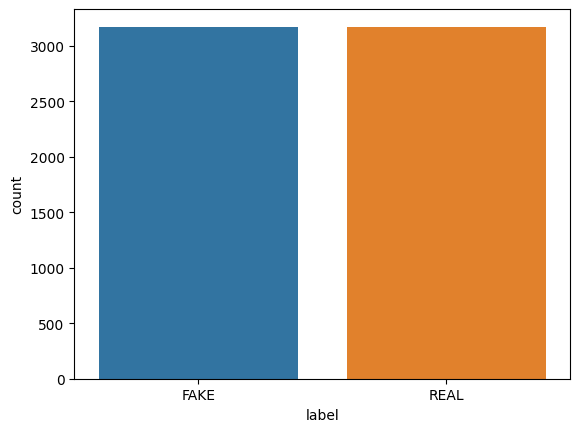

In [80]:
x=df.groupby('label', as_index=False).count()
sns.countplot(x=df['label'])
plt.show()

In [81]:
nltk.download('stopwords') # стоп-слова
nltk.download('punkt') # пунктуация
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Обработка датасета перед обучением

In [82]:
# Удаление знаков пунктуации и приведение к нижнему регистру
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

# Удаление стоп-слов
stop_words = set(stopwords.words('english'))
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

# Лематизация слов
wnl = WordNetLemmatizer()
df['title'] = df['title'].apply(lambda x: ' '.join([wnl.lemmatize(word) for word in word_tokenize(x)]))

# замена пробелов на нижнее подчеркивание
df['title'] = df['title'].str.replace(' ', '_')

# преобразуем 'label' в boolean формат
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})

In [83]:
df.head()

,Unnamed: 0,title,text,label
0,8476,smell_hillary_fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,watch_exact_moment_paul_ryan_committed_politic...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,kerry_go_paris_gesture_sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,bernie_supporter_twitter_erupt_anger_dnc_tried...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,battle_new_york_primary_matter,It's primary day in New York and front-runners...,1


<ipython-input-84-2ffb1af134ac>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['label'])


<Axes: xlabel='label', ylabel='Density'>

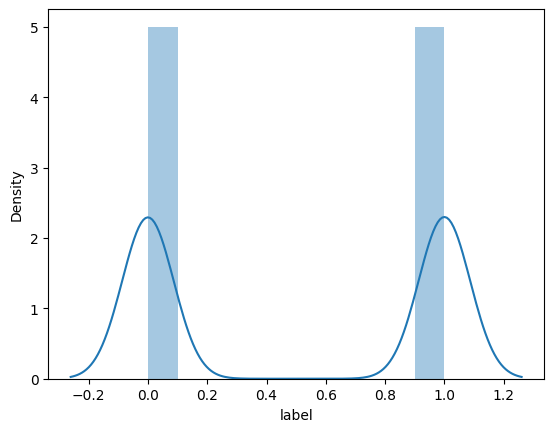

In [84]:
sns.distplot(df['label'])

## Раделение на тренировочную и тестовую выборки

In [85]:
# разделение данных на тренировочную (80%) и тестовую (20%) выборки
X = df['title']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42)

# рассмотрим информацию о размерах выборок
print("Размеры тренировочной выборки:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

print("Размеры тестовой выборки:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Размеры тренировочной выборки:
X_train: (5068,), y_train: (5068,)
Размеры тестовой выборки:
X_test: (1267,), y_test: (1267,)


In [86]:
# Тренировочные и тестовые данные
print("Тренировочные данные (x_train):")
print(X_train)

print("\nТестовые данные (x_test):")
print(X_test)

Тренировочные данные (x_train):
1142    alabama_sen_session_back_trump_immigration_pla...
2654    600_november_6th_trump_leading_major_national_...
5395              time_investigating_hillary_attack_woman
1170                                   woman_vote_husband
4371    pakistan_police_detain_dozen_imran_khan_suppor...
                              ...                        
3772    inane_spectacle_gop_debate_cruz_showboating_cr...
5191               clinton_fbigate_true_depth_obamageddon
5226    fearing_election_day_trouble_u_school_cancel_c...
5390           obama_get_away_whopper_gun_town_hall_event
860     ceta_canada_challenged_eu_chemical_regulation_...
Name: title, Length: 5068, dtype: object

Тестовые данные (x_test):
1357                             american_dream_revisited
2080     clinton_multiple_fbi_investigation_agent_stymied
2718    fbi_cant_actually_investigate_candidate_hillar...
812     confirmed_public_overwhelmingly_10to1_say_medi...
4886                  nanny_ja

In [87]:
# загрузка предварительно обученной модели BERT
BERT_HUGGING_MODEL = 'bert-base-uncased'
# загрузка предварительно обученного токенизатора BERT
tokenizer = BertTokenizer.from_pretrained(BERT_HUGGING_MODEL, do_lower_case=True) # нижний регистр

In [88]:
# Метод обработки текста для модели BERT
def preprocessing_for_bert(data):
    """Выполним необходимые предварительные шаги обработки данных для предварительно обученной модели BERT.
    @param    data (np.array): Массив текстов для обработки.
    @return   input_ids (torch.Tensor): Тензор идентификаторов токенов, который будет передан в модель.
    @return   attention_masks (torch.Tensor): Тензор индексов, указывающий, на какие
                  токены должна обращать внимание модель.
    """

    # создаем пустые списки для хранения результатов
    input_ids = []
    attention_masks = []

    # для каждого предложения...
    for sent in data:
        # Функция `encode_plus` выполнит следующие шаги:
        # 1. Токенизация предложения.
        # 2. Добавление токенов `[CLS]` и `[SEP]` в начало и конец.
        # 3. Усечение/дополнение предложения до максимальной длины.
        # 4. Сопоставление токенов и их идентификаторов.
        # 5. Создание маски внимания.
        # 6. Возврат словаря результатов.

        encoded_sent = tokenizer.encode_plus(
            sent,                           # Предобработанный текст, исходные
            add_special_tokens=True,        # Добавление `[CLS]` и `[SEP]`
            max_length=MAX_LEN,             # Максимальная длина для усечения/дополнения
            pad_to_max_length=True,         # Дополнение предложения до максимальной длины
            return_attention_mask=True      # Возврат маски внимания
        ) # {'input_ids':[...], 'attention_mask': [...]}

        # добавляем результаты в соответствующие списки
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))


    # преобразуем списки в тензоры
    input_ids = torch.tensor(input_ids) # обертка в тензор
    attention_masks = torch.tensor(attention_masks) # обертка в тензор

    return input_ids, attention_masks

## Подготовка данных для загрузки в BERT

In [89]:
# задаем максимальную длину последовательности
MAX_LEN = 128

# применим функцию 'preprocessing_for_bert' на тренировочном наборе данных и тестовом наборе данных
train_inputs, train_masks = preprocessing_for_bert(X_train)
test_inputs, test_masks = preprocessing_for_bert(X_test)

# рассморим информацию о 'train_masks' и 'train_inputs'
print("Train_masks:")
print(train_masks)

print("\nTrain_inputs:")
print(train_inputs)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train_masks:
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

Train_inputs:
tensor([[  101,  6041,  1035,  ...,     0,     0,     0],
        [  101,  5174,  1035,  ...,     0,     0,     0],
        [  101,  2051,  1035,  ...,     0,     0,     0],
        ...,
        [  101, 14892,  1035,  ...,     0,     0,     0],
        [  101,  8112,  1035,  ...,     0,     0,     0],
        [  101,  8292,  2696,  ...,     0,     0,     0]])


In [90]:
# Объекты данных перекодировать в массивы NumPy
if isinstance(y_train, pd.Series):
    y_train=y_train.to_numpy()

if isinstance(y_test, pd.Series):
    y_test=y_test.to_numpy()

# создаем тензоры PyTorch для меток
train_labels = torch.LongTensor(y_train)
test_labels = torch.LongTensor(y_test)

# определим размер batch size (16 или 32)
batch_size = 32

# создание 'RandomSampler' и 'DataLoader'
'''
train/test_inputs - Обработанные заголовки новостей
train/test_masks - Пропуски
train/test_label - Обозначение достоверности/фиктивности новостей
'''
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Инициализация классификатора BERT

In [91]:
# создаем классификатор на основе BERT
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        #Cкрытый размер BERT, скрытый размер нашего классификатора и количество меток
        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained(BERT_HUGGING_MODEL)
        #Однослойный классификатор с прямолинейным движением
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )
        # Нормировать модель
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    # Загружаем исходные данные
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # смотрим CLS - начало предложения (определяем отзыв)
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Подать входные данные в классификатор
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [92]:
# инициализируем модель
EPOCH_NUM = 5

def initialize_model(epochs=EPOCH_NUM):
    # создаем экземпляр BertClassifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # задаем устройство (GPU T4)
    bert_classifier.to(device)

    # создаем оптимизатор
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,
                      eps=1e-8
                      )

    # делаем расчет циклов для работы
    total_steps = len(train_dataloader) * epochs

    # загрузчик, расписание (последовательность) и число циклов для обучения
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [93]:
# Бинарная классификация
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=1):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, test_dataloader=None, epochs=EPOCH_NUM, evaluation=False):
    """

      Тренировка BertClassifier model

    """
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # измерение времени (elapsed time of each epoch)
        t0_epoch, t0_batch = time.time(), time.time()

        # обнулить переменные
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # перевод в режим тренировки
        model.train()

        # для каждого batch
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # загружаем каждую batch в GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # использование нулевого градиента
            model.zero_grad()

            # добавляем в модель id и маски
            logits = model(b_input_ids, b_attn_mask)

            # считаем потери (Кросс Энтропия)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # расчет градиентов функцией backward
            loss.backward()

            # решение проблемы "взрывных градиентов"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # обновляем шаг для оптимизатора и расписания
            optimizer.step()
            scheduler.step()

            # печатаем значения для каждых 20 batch
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # время расчета 20 batches
                time_elapsed = time.time() - t0_batch

                # результаты
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # обнулим переменные
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # средняя функция потерь
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Оценка
        # =======================================
        if evaluation == True:
            # считается точность
            test_loss, test_accuracy = evaluate(model, test_dataloader)

            # общее время, затраченное на измерение
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

In [94]:
# определим функцию вычисления показателей качества модели (функцию потерь и точность)
def evaluate(model, test_dataloader):

    model.eval()

    test_accuracy = []
    test_loss = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

# Обучение данных моделью BERT

In [95]:
device = torch.device("cuda")

In [96]:
# обучение модели
set_seed(1)
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train(bert_classifier, train_dataloader, test_dataloader, epochs=5, evaluation=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.631665   |     -      |     -     |   14.46  
   1    |   40    |   0.509789   |     -      |     -     |   14.05  
   1    |   60    |   0.563858   |     -      |     -     |   13.43  
   1    |   80    |   0.453990   |     -      |     -     |   12.97  
   1    |   100   |   0.436837   |     -      |     -     |   12.82  
   1    |   120   |   0.513925   |     -      |     -     |   12.88  
   1    |   140   |   0.477340   |     -      |     -     |   13.08  
   1    |   158   |   0.416971   |     -      |     -     |   11.54  
----------------------------------------------------------------------
   1    |    -    |   0.502423   |  0.392620  |   82.96   |  114.84  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
---------------

# Оценка качества модели

In [97]:
# загрузим натренированную модель
def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Сбор из каждого batch результатов в один объект
    all_logits = torch.cat(all_logits, dim=0)

    # Для вероятности принадлежности к классу
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [98]:
# построим график ROC-кривой для наглядной оценки качества предсказания
def evaluate_roc(probs, y_true):

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # ROC AUC
    plt.title('Оценка ROC AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [101]:
# вычислим предсказанные вероятности на тестовых данных
probs = bert_predict(bert_classifier, test_dataloader)
probs

array([[0.996718  , 0.00328203],
       [0.9975364 , 0.00246359],
       [0.9963432 , 0.00365681],
       ...,
       [0.00387559, 0.99612445],
       [0.00451047, 0.99548954],
       [0.00402356, 0.9959765 ]], dtype=float32)

In [120]:
# Посмотрим на результаты прогноза модели
y_test = y_test.tolist()
# Заменим boolean значения label на текстовые (FAKE,REAL)
for index, item in enumerate(y_test):
  if item == 0:
    y_test[index] = 'FAKE'
  elif item == 1:
    y_test[index] = 'REAL'

# Датасет с процентным соотношением определения правдивости/фиктивности новостного тега
new_data = {'Title': X_test.tolist(),
        'TRUE_LABEL': y_test}
df_new = pd.DataFrame(new_data)
df_new['Predict REAL %'] = [probs[i][1] for i in range(0,len(probs))]
df_new['Predict FAKE %'] = [probs[i][0] for i in range(0,len(probs))]
df_new

,Title,TRUE_LABEL,Predict REAL %,Predict FAKE %
0,american_dream_revisited,FAKE,0.003282,0.996718
1,clinton_multiple_fbi_investigation_agent_stymied,FAKE,0.002464,0.997536
2,fbi_cant_actually_investigate_candidate_hillar...,FAKE,0.003657,0.996343
3,confirmed_public_overwhelmingly_10to1_say_medi...,FAKE,0.004141,0.995858
4,nanny_jail_force_feeding_baby_death,FAKE,0.648344,0.351656
...,...,...,...,...
1262,tennessee_child_brittle_bone_suffer_state_care...,FAKE,0.026363,0.973637
1263,closed_primary_warped_democracy,REAL,0.996010,0.003990
1264,liberal_plan_defeat_isi_here_avoid_ted_cruzs_r...,REAL,0.996124,0.003876
1265,nobody_vp_debate_least_american_electorate,REAL,0.995490,0.004510


Модель показала отличный результат (без особого труда по процентным показателям можно понять какая новость является реальной, а какая - фейком). Данную технологию можно использовать на новостных форумах открытого доступа, где люди будут загружать новости, а система автоматически оценивать их подлинность в процентном соотношении.

AUC: 0.9172
Accuracy: 83.66%


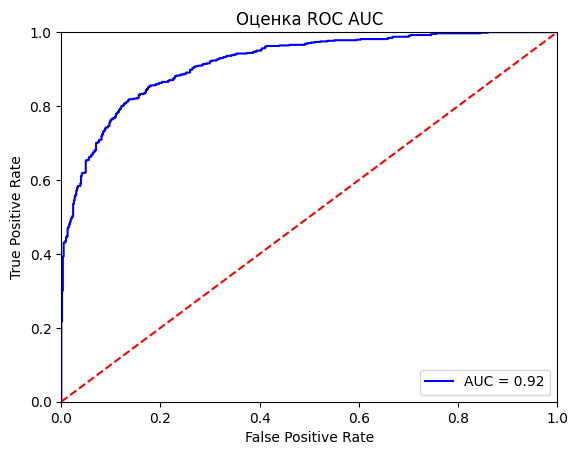

In [102]:
# оценим Bert classifier
evaluate_roc(probs, y_test)